In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from datasets import HousingDatasets
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from scipy.optimize import curve_fit

color_list = list(mcolors.TABLEAU_COLORS.keys())
plt.rcParams["figure.figsize"] = (12, 4)

def plot_recessions(df):
    # Adding shaded regions for where the recession is
    for _, row in recessions.iterrows():
        if row['End'] > df['date'].min():
            plt.axvspan(row['Start'], row['End'], color='gray', alpha=0.3)

datasets = HousingDatasets()
recessions = datasets.load_recessions()
display(recessions.tail())

Name      Start        End  Peak unemployment  \
10    1981–1982 recession 1981-07-01 1982-11-01              0.108   
11  Early 1990s recession 1990-07-01 1991-03-01              0.078   
12  Early 2000s recession 2001-03-01 2001-11-01              0.063   
13        Great Recession 2007-12-01 2009-06-01              0.100   
14     COVID-19 recession 2020-02-01 2020-04-01              0.147   

   GDP decline (peak to trough)  \
10                        −2.7%   
11                        −1.4%   
12                        −0.3%   
13                        −5.1%   
14                       −19.2%   

                                      Characteristics  
10  The Iranian Revolution sharply increased the p...  
11  After the lengthy peacetime expansion of the 1...  
12  The 1990s were the longest period of economic ...  
13  The subprime mortgage crisis led to the collap...  
14  The economic effects of the pandemic were seve...

In [3]:
from darts import TimeSeries, concatenate
from darts.utils.utils import ModelMode
from darts.utils.callbacks import TFMProgressBar
from darts.utils.statistics import plot_acf, plot_pacf, check_seasonality, stationarity_test_adf, stationarity_tests, extract_trend_and_seasonality
from darts.metrics import mape, smape, mae
from darts.dataprocessing.transformers import Scaler, Diff
from darts.dataprocessing import dtw
from darts.models import *

c:\Users\eric_\miniconda3\envs\py3115\Lib\site-packages\darts\timeseries.py:732: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  xa = xr.DataArray(


<Axes: xlabel='date'>

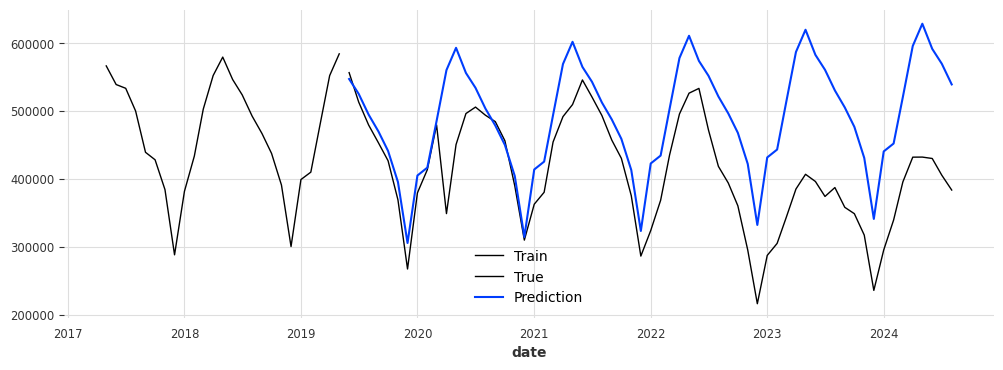

In [4]:
new_listings = datasets.load_new_listings()
# plt.plot(new_listings.date, new_listings.value)

series = TimeSeries.from_dataframe(new_listings, time_col='date')
_, series = series.split_before(pd.Timestamp('2017-05-01'))
train, test = series.split_after(pd.Timestamp('2019-05-01'))

seasonal_model = NaiveSeasonal(K=12)
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(len(test))

drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(len(test))

combined_forecast = drift_forecast + seasonal_forecast - train.last_value()

train.plot(label='Train', linewidth=1, color='black')
test.plot(label='True', linewidth=1, alpha=1)
combined_forecast.plot(label="Prediction", linewidth=1.5)

c:\Users\eric_\miniconda3\envs\py3115\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


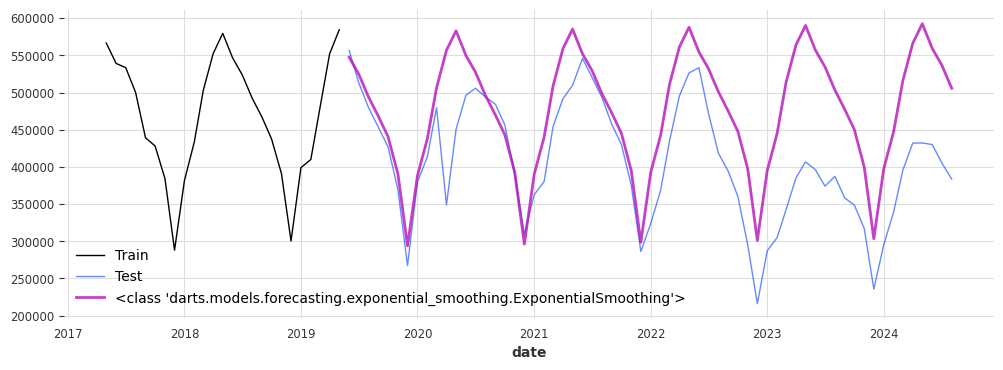

In [5]:
model = ExponentialSmoothing(seasonal_periods=12)
model.fit(train)
pred = model.predict(len(test))
train.plot(label='Train', linewidth=1)
test.plot(label='Test', linewidth=1, alpha=0.6)
pred.plot(label=f'{ExponentialSmoothing}', alpha=0.8)
plt.show()


In [43]:
# Thoughts: probabilistic approach, historically when we have seen this rate of change, what occured next?

In [9]:
new_house_supply = TimeSeries.from_dataframe(datasets.load_new_house_supply(), time_col='date')
new_house_started = TimeSeries.from_dataframe(datasets.load_new_house_started(), time_col='date')

normalized_new_house_started = new_house_started / new_house_started.mean(axis=0).first_value()
normalized_new_house_supply = new_house_supply / new_house_supply.mean(axis=0).first_value()
# CostMatrix

# dwt = DTWAlignment(new_house_supply, new_house_started)

c:\Users\eric_\miniconda3\envs\py3115\Lib\site-packages\darts\timeseries.py:732: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  xa = xr.DataArray(
c:\Users\eric_\miniconda3\envs\py3115\Lib\site-packages\darts\timeseries.py:732: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable const

<Axes: xlabel='date'>

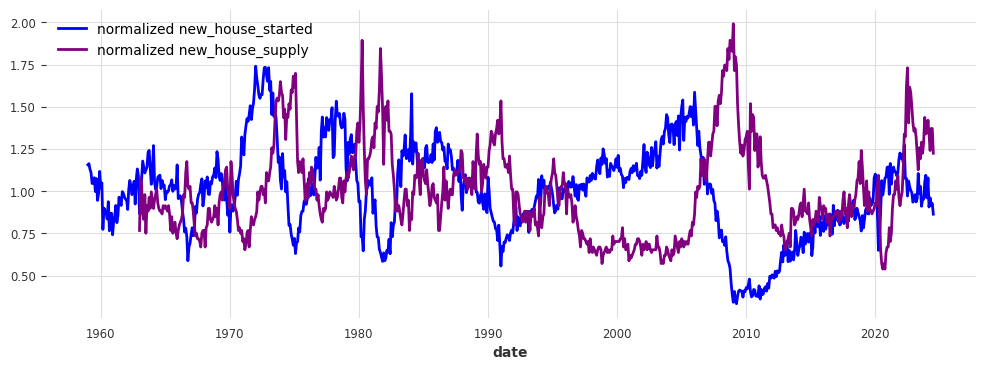

In [115]:
(normalized_new_house_started).plot(label='normalized new_house_started', color='blue')
(normalized_new_house_supply).plot(label='normalized new_house_supply', color='purple') 

New house starts and supply have been closely linked after the fallout of the 2008 recession, implying a healthier housing market.

Text(0.5, 1.0, 'Warp Alignment')

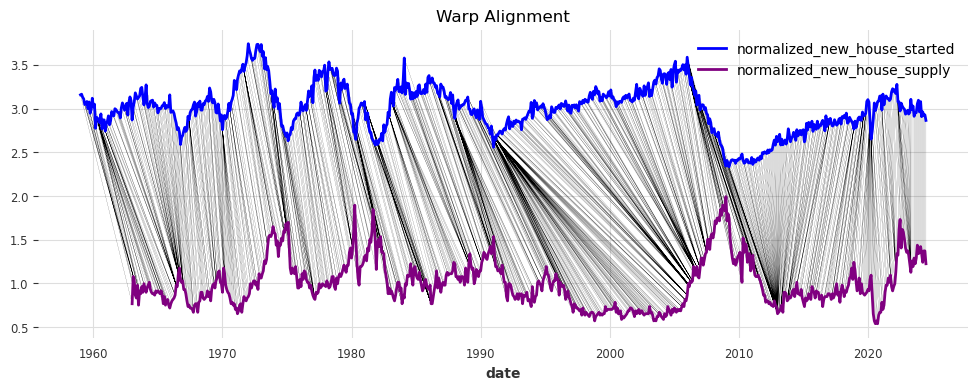

In [117]:
exact_alignment = dtw.dtw(normalized_new_house_started, normalized_new_house_supply)
# exact_alignment.plot(show_series=True)

exact_alignment.plot_alignment(series1_y_offset=2, 
                               args_series1={'label':'normalized_new_house_started', 'color':'blue'}, 
                               args_series2={'label':'normalized_new_house_supply', 'color':'purple'}, 
                               args_line={'linewidth': .1})
plt.gca().set_title("Warp Alignment")

<Axes: xlabel='date'>

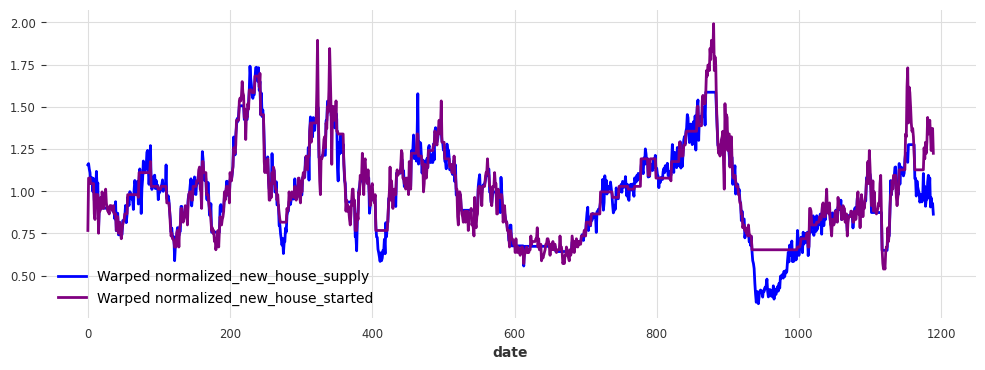

In [119]:
warped_ts, warped_ts_shape = exact_alignment.warped()

warped_ts.plot(label="Warped normalized_new_house_supply", color='blue')
warped_ts_shape.plot(label="Warped normalized_new_house_started", color='purple')

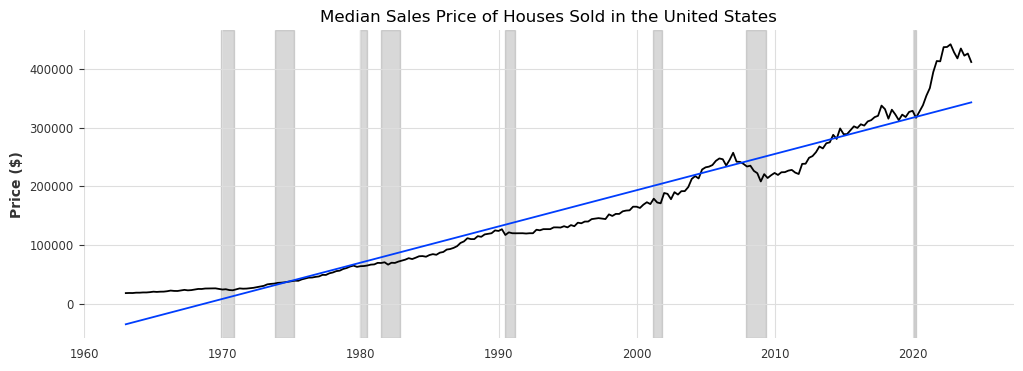

In [10]:
median_house_price = datasets.load_median_house_price()

reg = linear_model.LinearRegression()
X = median_house_price.index.to_numpy().reshape(-1, 1)
reg.fit(X, median_house_price.value.to_numpy().reshape(-1, 1))
pred = reg.predict(X)

plt.plot(median_house_price.date, median_house_price.value)
plt.plot(median_house_price.date, pred)
plt.title('Median Sales Price of Houses Sold in the United States')
plt.ylabel('Price ($)')
plot_recessions(median_house_price)

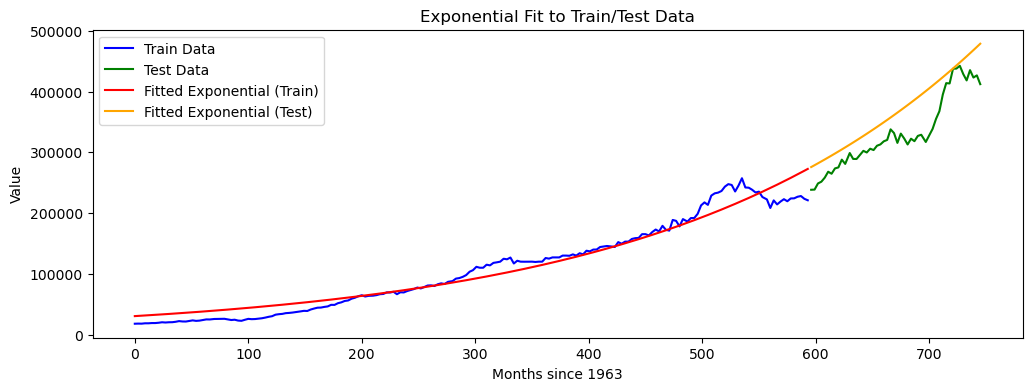

Fitted parameters: a = 30328.55427401279, b = 0.003703944804017124


In [27]:
median_house_price['months'] = (median_house_price['date'] - median_house_price['date'].min()).dt.days // 30

X_train, X_test, y_train, y_test = train_test_split(median_house_price['months'], median_house_price['value'], test_size=0.2, random_state=42, shuffle=False)

# Define the exponential function y = a * exp(b * x)
def exponential_func(x, a, b):
    return a * np.exp(b * np.array(x))

# Fit the exponential curve on training data
popt, pcov = curve_fit(exponential_func, X_train, y_train, p0=(1, 0.01))  # Initial guess for a, b
print(f"Fitted parameters: a = {popt[0]}, b = {popt[1]}")

# Predict on training and test data
y_train_pred = exponential_func(X_train, *popt)
y_test_pred = exponential_func(X_test, *popt)

plt.plot(X_train, y_train, label='Train Data', color='blue')
plt.plot(X_test, y_test, label='Test Data', color='green')
plt.plot(sorted(X_train), exponential_func(sorted(X_train), *popt), label='Fitted Exponential (Train)', color='red')
plt.plot(sorted(X_test), exponential_func(sorted(X_test), *popt), label='Fitted Exponential (Test)', color='orange')
plt.xlabel(f'Months since {median_house_price["date"].min().year}')
plt.ylabel('Value')
plt.title('Exponential Fit to Train/Test Data')
plt.legend()
plt.show()

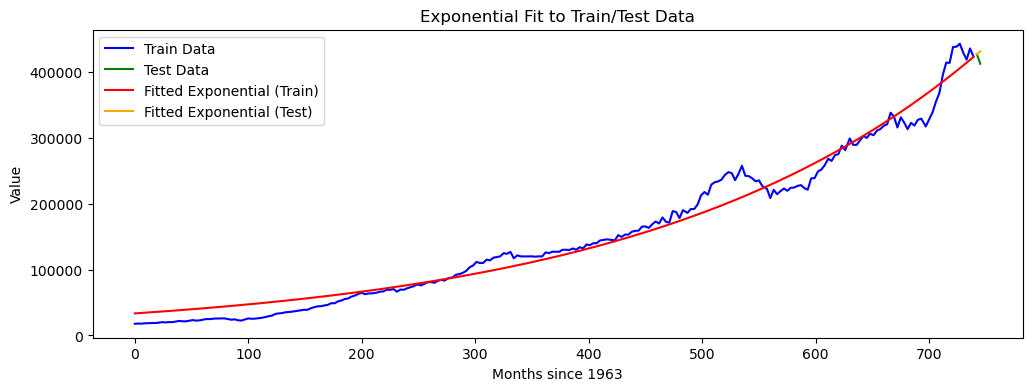

Fitted parameters: a = 33461.52103318388, b = 0.0034310691104013666


In [61]:
X_train, X_test, y_train, y_test = train_test_split(median_house_price['months'], median_house_price['value'], test_size=0.005, random_state=42, shuffle=False)
# Fit the exponential curve on training data
popt, pcov = curve_fit(exponential_func, X_train, y_train, p0=(1, 0.01))  # Initial guess for a, b
print(f"Fitted parameters: a = {popt[0]}, b = {popt[1]}")

# Predict on training and test data
y_train_pred = exponential_func(X_train, *popt)
y_test_pred = exponential_func(X_test, *popt)

plt.plot(X_train, y_train, label='Train Data', color='blue')
plt.plot(X_test, y_test, label='Test Data', color='green')
plt.plot(sorted(X_train), exponential_func(sorted(X_train), *popt), label='Fitted Exponential (Train)', color='red')
plt.plot(sorted(X_test), exponential_func(sorted(X_test), *popt), label='Fitted Exponential (Test)', color='orange')
plt.xlabel(f'Months since {median_house_price["date"].min().year}')
plt.ylabel('Value')
plt.title('Exponential Fit to Train/Test Data')
plt.legend()
plt.show()

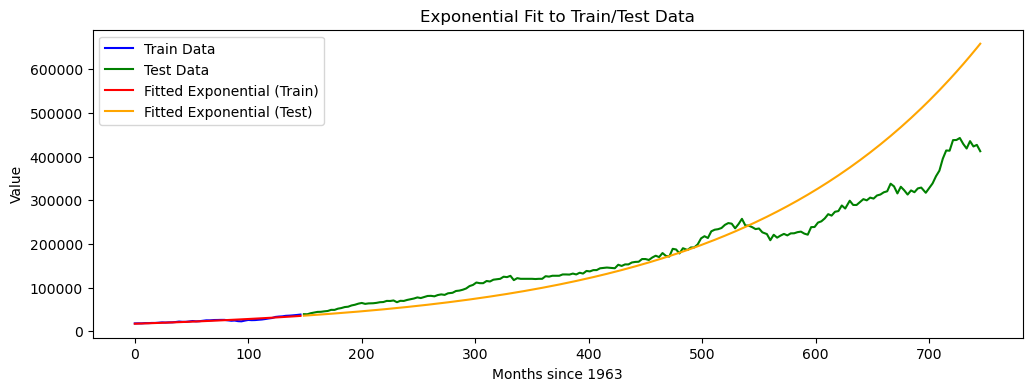

Fitted parameters: a = 17120.537940412578, b = 0.004899037067459678


In [62]:
X_train, X_test, y_train, y_test = train_test_split(median_house_price['months'], median_house_price['value'], test_size=0.8, random_state=42, shuffle=False)
# Fit the exponential curve on training data
popt, pcov = curve_fit(exponential_func, X_train, y_train, p0=(1, 0.01))  # Initial guess for a, b
print(f"Fitted parameters: a = {popt[0]}, b = {popt[1]}")

# Predict on training and test data
y_train_pred = exponential_func(X_train, *popt)
y_test_pred = exponential_func(X_test, *popt)

plt.plot(X_train, y_train, label='Train Data', color='blue')
plt.plot(X_test, y_test, label='Test Data', color='green')
plt.plot(sorted(X_train), exponential_func(sorted(X_train), *popt), label='Fitted Exponential (Train)', color='red')
plt.plot(sorted(X_test), exponential_func(sorted(X_test), *popt), label='Fitted Exponential (Test)', color='orange')
plt.xlabel(f'Months since {median_house_price["date"].min().year}')
plt.ylabel('Value')
plt.title('Exponential Fit to Train/Test Data')
plt.legend()
plt.show()


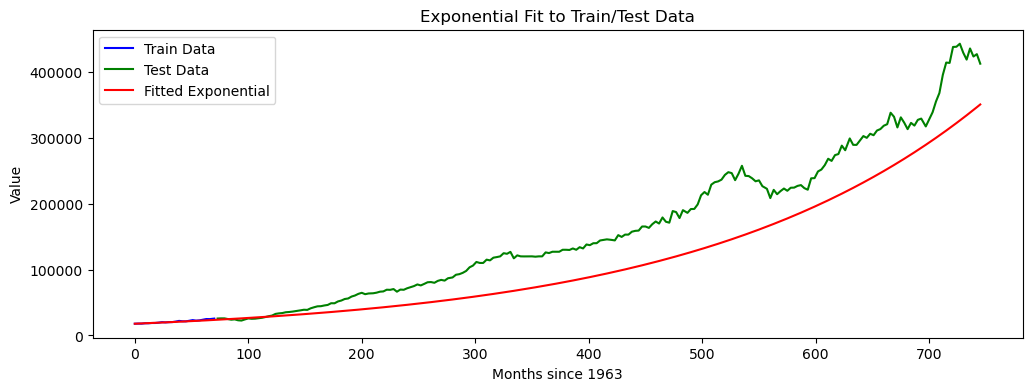

Fitted parameters: a = 17800.0, b = 0.004


In [53]:
popt = [median_house_price.iloc[0]['value'], 0.004]
print(f"Fitted parameters: a = {popt[0]}, b = {popt[1]}")

plt.plot(X_train, y_train, label='Train Data', color='blue')
plt.plot(X_test, y_test, label='Test Data', color='green')
plt.plot(sorted(median_house_price['months']), exponential_func(sorted(median_house_price['months']), *popt), label='Fitted Exponential', color='red')
plt.xlabel(f'Months since {median_house_price["date"].min().year}')
plt.ylabel('Value')
plt.title('Exponential Fit to Train/Test Data')
plt.legend()
plt.show()
print(f"Fitted parameters: a = {popt[0]}, b = {popt[1]}")